In [2]:
from xmlrpc.client import _datetime_type

import matplotlib.pyplot as plt
import numpy as np
import math
import cmath

__Propogation matrix function__

In [3]:
## matrix which describes propagation of light within layer 
## k_x - wavenumber along x; d - thickness of layer; 
## epsilon - dielectric constant of the layer; k_0 - wavenumber in vaccum
def t_propogation(k_0, k_x, d, epsilon):
    k_z = (k_0**2*epsilon - k_x**2)**(1/2)
    T = np.zeros((2,2), dtype=np.complex128)
    T[0][0] = np.exp(1j*k_z*d)
    T[1][1] = np.exp(-1j*k_z*d)
    return T

__Interface matrix function__

In [4]:
## matrix which describes boundary conditions on the interface; 
## e_1 - dielectric constant of layer from which light incident, 
## e_2 - dielectric constant of the second layer
def t_interface(polarization, e_1, e_2, k_x, k_0):
    k_z_1 = (k_0 ** 2 * e_1 - k_x ** 2)**(1/2)
    k_z_2 = (k_0 ** 2 * e_2 - k_x ** 2)**(1/2)
    F_1 = np.ones((2,2), dtype=np.complex128)
    F_2 = np.ones((2,2), dtype=np.complex128)
    if polarization == 1: # s-polarization
        F_1[1][0] = -k_z_1/k_0
        F_1[1][1] = k_z_1/k_0
        F_2[1][0] = -k_z_2 / k_0
        F_2[1][1] = k_z_2 / k_0
    else:                 # p-polarization
        F_1[0][0] = k_z_1/(k_0 * e_1)
        F_1[0][1] = k_z_1/(k_0 * e_1)
        F_1[1][1] = -1
        F_2[0][0] = k_z_2 / (k_0 * e_2)
        F_2[0][1] = k_z_2 / (k_0 * e_2)
        F_2[1][1] = -1
    F = np.zeros((2,2), dtype=np.complex128)
    inverse_F_2 = np.linalg.inv(F_2)
    F = inverse_F_2 @ F_1
    return F

__Define Gauss beam parameters__

In [59]:
def gaussian(x, width,  E_0=1):
    return E_0 * np.exp(-x**2 / 4 / width**2) * (2 * np.pi)**(-.25) *width**(-.5)

In [60]:
def gaussian_fourier(k_x, width, E_0=1):
    return E_0 * np.exp(-k_x**2 / width**2) / (2**(-.25) * np.pi) * width**(.5)

__Chebychev grid__

In [42]:
# make chebyshev grid
def chebyshev_grid(N, wavelength):
    k_0 = 2*np.pi/wavelength
    
    g = lambda k: np.cos(np.pi*(2*k + 1)/(2*(N + 1)))
    x = np.linspace(0, N, N+1)
    return k_0*g(x) #[1:][:-1]

def uniform_grid(N, wavelength):
    k_0 = 2*np.pi/wavelength
    
    x = np.linspace(-k_0, k_0, N)
    
    return x[1:][:-1]

__Calculation of transmission and reflection for angular representation__
k_x_old, k_z_old - in the beam reference

In [8]:
def find_TMM(angle, wavelength, epsilon_list, width_list, pol=0):
    T = np.array([[1, 0], [0, 1]])
   
    k_0 = 2*np.pi/wavelength
    k_x = k_0*np.sin(np.pi*angle/180)*epsilon_list[0]**(1./2)
        
    for i in range(len(epsilon_list)):
        if i != len(epsilon_list)-1:
            if i == 0:
                eps1 = epsilon_list[0]
                eps2 = epsilon_list[1]
                T = t_interface(pol, eps1, eps2, k_x, k_0) @ T
            else:
                eps1 = epsilon_list[i]
                eps2 = epsilon_list[i+1]
                    
                T = t_propogation(k_0, k_x, width_list[i-1], eps1) @ T                   
                T = t_interface(pol, eps1, eps2, k_x, k_0) @ T
        else:
            break
    
    return T        

__Calculation of reflection__

 $$ TTM = \frac1{t_{21}} \begin{bmatrix}
           t_{12}t_{21}-r_{12}r_{21} & r_{21} \\
           -r_{12} & 1 \\
         \end{bmatrix} $$

In [9]:
def find_r_t(T):
    t_21 = 1/T[1][1]
    r_21 = T[0][1] * t_21
    
    r_12 = -T[1][0] * t_21
    t_12 = T[0][0] + r_12 * r_21 / t_21
    
    return r_12, t_12        

In [18]:
def phi_plane_wave(angle, k_x_old, wavelength):
    k_0 = 2*np.pi/wavelength
    k_z_old = np.sqrt(k_0**2 - k_x_old**2)
        
    k_x = np.cos(np.pi * angle / 180) * k_x_old + np.sin(np.pi * angle / 180) * k_z_old
    k_z = -np.sin(np.pi * angle / 180) * k_x_old + np.cos(np.pi * angle / 180) * k_z_old
    
    phi = abs(np.arctan(k_x / k_z))
    
    return phi

In [38]:
#PARAMETERS
wavelength = 1550
k_0 = 2*np.pi/wavelength

e_prism = np.complex(4, 0) # refractive index of prism, in future we will make iteration
e_mos2 = np.complex(14.080688, 0)
e_gold = np.complex(118.94878, 13.01471)

theta = 40

gold_thickness = 30 # thickness of gold in future we will make iterations

pol = 0 # 0 - p-polarization; consider only this polarization because s-polarization cann't induce plasmon polariton

epsilon_list = [e_prism, e_gold, e_mos2, 1]
width_list = [gold_thickness, .73]

weight_t = []

weight_r = []

for k_x_old in chebyshev_grid(30, wavelength):
    phi = phi_plane_wave(theta, k_x_old, wavelength)
    
    TMM = find_TMM(angle=phi, wavelength=wavelength, epsilon_list=epsilon_list, width_list=width_list)            

    r, t = find_r_t(TMM)

    weight_t.append(t)
    
    weight_r.append(r)

In [39]:
def lagranz(x,y,t): # lagranz interpolation
    z=0
    for j in range(len(y)):
        num = 1; den = 1
        for i in range(len(x)):
            if i==j:
                num = num*1; den = den*1   
            else: 
                num = num*(t-x[i])
                den = den*(x[j]-x[i])
        z=z+y[j]*num/den
    return z

$$\int_{-k}^{k}dk_x^{'}E_w[k_x^{'}] t[k_x^{'}]e^{ik_x^{'}x}$$

In [103]:
def integral_t_E_fourier(x, angle_old, wavelength, epsilon_list, width_list, gauss_width=1e3, E_0=1, 
                N_points = 30, grid_method=uniform_grid):
    k_0 = 2*np.pi/wavelength
    Int = 0
    k_x_old_1 = -k_0
    
    
    for k_x_old in grid_method(N_points, wavelength):
        phi = phi_plane_wave(angle_old, k_x_old, wavelength)
    
        TMM = find_TMM(angle=phi, wavelength=wavelength, epsilon_list=epsilon_list, 
                       width_list=width_list)            

        _, t = find_r_t(TMM)
        E_k_x_old = gaussian_fourier(k_x_old, gauss_width, E_0)
        E_x_old_transformed = t * E_k_x_old * np.exp(1j*k_x_old*x)
        #print(E_x_old_transformed)
        #take into account absence of boundary points -k_0 and k_0 does not include into consideration
         
        delta_k = k_x_old - k_x_old_1
        
        Int += delta_k * E_x_old_transformed
        k_x_old_1 = k_x_old
        
    return Int

In [119]:
def integral_x_old(angle_old, wavelength, epsilon_list, width_list, gauss_width=1e3, 
                   E_0=1, N_x_points=400, N_points = 30, grid_method=uniform_grid):
    
    Int = 0
    interval = np.linspace(-2*gauss_width, 0, N_x_points) #cut positive side because of symmetry
    #x1 = -np.inf
    for x in interval:
        
        Int_t_E = integral_t_E_fourier(x, angle_old, wavelength, epsilon_list, width_list, E_0=E_0,  
                             gauss_width=gauss_width,N_points = N_points, grid_method=grid_method)
        #print('Int_t_E', Int_t_E)
        if x == interval[0]:
            x1 = x
        x2 = x
        delta_x = x2 - x1
        
        Int += delta_x * abs(Int_t_E)**2
       # print(delta_x,'*** Int', Int)
        x1 = x
    return 2*Int

In [117]:
def integral_x_old_normirovka(angle_old, wavelength, gauss_width=1e3, 
                   E_0=1, N_x_points=50, N_points = 50, grid_method=uniform_grid):
    Int = 0
    Int_E = 0
    interval = np.linspace(-2*gauss_width, 0, N_x_points) #cut positive side because of symmetry
    
    k_0 = 2*np.pi/wavelength
    k_x_old_1 = -k_0
    
    for x in interval:
        for k_x_old in grid_method(N_points, wavelength):
            E_k_x_old = gaussian_fourier(k_x_old, gauss_width, E_0)
            E_x_old_transformed = E_k_x_old * np.exp(1j*k_x_old*x)
        #take into account absence of boundary points -k_0 and k_0 does not include into consideration
            delta_k = k_x_old - k_x_old_1
            Int_E += delta_k * E_x_old_transformed
            #if x == 0:
            #    print(Int_E)
            k_x_old_1 = k_x_old
        
        if x == interval[0]:
            x1 = x
        x2 = x
        delta_x = x2 - x1
        
        Int += delta_x * abs(Int_E)**2
        x1 = x
        
    return 2*Int

In [118]:
integral_x_old_normirovka(angle_old=theta, wavelength=wavelength)

2611.3589143529653

In [108]:
integral_t_E_fourier(0, theta, wavelength, epsilon_list, width_list, gauss_width=1e3, E_0=1, 
                N_points = 10, grid_method=uniform_grid)

(0.0020165075234850225+0.015395869156774412j)

In [120]:
integral_x_old(theta, wavelength, epsilon_list, width_list)

0.22057865952289155

__Plot results__

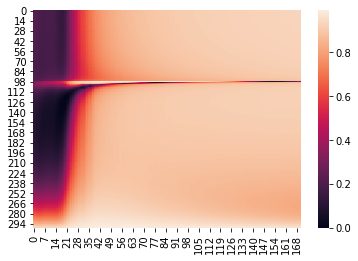

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import seaborn as sb

x = frequency_range
y = theta

x, y = np.meshgrid(x, y)

z = reflection

ax = sb.heatmap(z)
# ax.invert_yaxis()

In [23]:
for i in range(len(theta)):
    print(reflection[i][15])

0.16479494510800108
0.16478496802807435
0.16477247874187323
0.16475750975590953
0.16474010031222913
0.1647202964439005
0.16469815104056404
0.16467372392435398
0.1646470819365602
0.16461829903545094
0.16458745640573627
0.1645546425802105
0.16451995357418575
0.1644834930333877
0.16444537239607573
0.16440571107022006
0.1643646366266634
0.16432228500929358
0.16427880076335738
0.16423433728316272
0.16418905708054535
0.16414313207561596
0.16409674391145776
0.1640500842946115
0.16400335536338623
0.16395677008622253
0.16391055269258348
0.1638649391391006
0.1638201776139854
0.1637765290830386
0.16373426788095222
0.1636936823519866
0.16365507554456865
0.16361876596484531
0.16358508839480584
0.16355439478121683
0.16352705520233762
0.163503458920203
0.16348401552717814
0.16346915619654934
0.1634593350481011
0.16345503064100708
0.163456747607902
0.16346501844580755
0.16348040548162004
0.1635035030322293
0.16353493978206388
0.16357538140399278
0.1636255334531678
0.16368614456762218
0.163758010014382

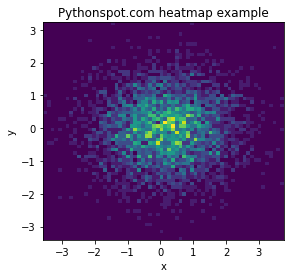

In [24]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 
# Create data
x = np.random.randn(4096)
y = np.random.randn(4096)
 
# Create heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
 
# Plot heatmap
plt.clf()
plt.title('Pythonspot.com heatmap example')
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, extent=extent)
plt.show()